In [78]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
import pickle
import time
from sklearn.ensemble import GradientBoostingClassifier 
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier # model 
from xgboost import plot_importance
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint
import sklearn.svm as svm


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [246]:
import sys   
!{sys.executable} -m pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [2]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) #넘파이를 사용할 경우
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
    
seed_everything(37) # Seed 고정

# Data Load

In [93]:
#데이터프레임 불러오기
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [50]:
subGBM = pd.read_csv('./sample_submission.csv')
subRFSVM = pd.read_csv('./sample_submission.csv')

In [10]:
train_df['LINE'].unique()

array(['T050304', 'T050307', 'T010306', 'T010305', 'T100304', 'T100306'],
      dtype=object)

In [94]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA 데이터 분석

In [4]:
hier = train_df[train_df['X_1'].isnull()].groupby(['PRODUCT_CODE', 'LINE'])['X_1'].count()
hier

PRODUCT_CODE  LINE   
A_31          T010305    0
              T010306    0
              T050304    0
              T050307    0
Name: X_1, dtype: int64

In [5]:
train_df[train_df['PRODUCT_CODE']== 'O_31']

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305']

In [108]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T010305')]
#train_df_pl = train_df[train_df['PRODUCT_CODE']=='A_31']
train_df_pl.iloc[:,986:1006]

,X_981,X_982,X_983,X_984,X_985,X_986,X_987,X_988,X_989,X_990,X_991,X_992,X_993,X_994,X_995,X_996,X_997,X_998,X_999,X_1000
28,24.6,24.441935,24.3,74.5,74.383871,74.3,1.0,1.0,1.0,NaN,NaN,0.0,1507.0,1507.000000,1507.0,180076.0,180054.25810,180034.0,541.0,541.0
33,24.3,24.254839,24.2,73.4,73.303226,73.2,1.0,1.0,1.0,NaN,NaN,0.0,323.0,322.516129,322.0,37342.0,37322.58065,37302.0,107.0,107.0
39,24.5,24.341935,24.2,74.0,73.967742,73.9,1.0,1.0,1.0,NaN,NaN,0.0,258.0,257.935484,257.0,30363.0,30341.58065,30322.0,92.0,92.0
40,25.1,24.964516,24.8,73.3,73.196774,73.1,1.0,1.0,1.0,NaN,NaN,0.0,924.0,924.000000,924.0,115928.0,115908.70970,115888.0,331.0,331.0
41,25.2,25.006452,24.8,73.2,73.129032,73.1,1.0,1.0,1.0,NaN,NaN,0.0,938.0,937.354839,937.0,117438.0,117416.58060,117397.0,336.0,336.0
48,24.3,24.148387,24.0,74.3,74.267742,74.2,1.0,1.0,1.0,NaN,NaN,0.0,1036.0,1036.000000,1036.0,124324.0,124303.93550,124283.0,402.0,402.0
52,24.3,24.232258,24.1,74.6,74.506452,74.5,1.0,1.0,1.0,NaN,NaN,0.0,240.0,240.000000,240.0,29062.0,29042.41935,29021.0,91.0,91.0
57,24.6,24.441935,24.2,74.6,74.512903,74.5,1.0,1.0,1.0,NaN,NaN,0.0,1538.0,1538.000000,1538.0,196685.0,196663.83870,196644.0,555.0,555.0
58,24.5,24.290625,24.2,74.1,73.993750,73.9,1.0,1.0,1.0,NaN,NaN,0.0,1566.0,1566.000000,1566.0,200477.0,200454.40630,200432.0,565.0,565.0
59,24.5,24.334375,24.1,75.0,74.887500,74.8,1.0,1.0,1.0,NaN,NaN,0.0,1624.0,1623.812500,1623.0,207968.0,207947.50000,207927.0,586.0,586.0


In [113]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T010306')] #70row
train_df_pl.iloc[:,336:356] 

,X_331,X_332,X_333,X_334,X_335,X_336,X_337,X_338,X_339,X_340,X_341,X_342,X_343,X_344,X_345,X_346,X_347,X_348,X_349,X_350
27,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00061,0.00095,0.00049,18.0,0.000084,0.000100,0.000062
31,127.0,128.0,127.0,130.0,37.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00086,0.00140,0.00081,18.0,0.000086,0.000098,0.000061
32,128.0,128.0,127.0,130.0,35.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00077,0.00130,0.00072,18.0,0.000088,0.000100,0.000064
38,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.22,0.22,2.0,0.00083,0.00091,0.00081,18.0,0.000093,0.000110,0.000068
47,127.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00083,0.00110,0.00078,18.0,0.000089,0.000100,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00079,0.00120,0.00074,18.0,0.000088,0.000097,0.000068
501,128.0,128.0,128.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00078,0.00130,0.00071,18.0,0.000095,0.000110,0.000065
523,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00076,0.00130,0.00051,18.0,0.000094,0.000110,0.000065
531,128.0,128.0,127.0,130.0,35.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00081,0.00140,0.00076,18.0,0.000089,0.000099,0.000067


In [51]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T050304')] #78rows
train_df_pl.iloc[:,246:266] 

,X_241,X_242,X_243,X_244,X_245,X_246,X_247,X_248,X_249,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,X_260
0,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,999.0,35.7,35.7,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T050307')]
train_df_pl.iloc[:,246:266] 

,X_241,X_242,X_243,X_244,X_245,X_246,X_247,X_248,X_249,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,X_260
1,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305']

In [174]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 90:110]

,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100,X_101,X_102,X_103,X_104
22,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000043,0.000057,0.000030,NaN
23,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000042,0.000053,0.000027,NaN
25,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0014,0.0013,18.0,0.000037,0.000047,0.000028,NaN
29,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0014,0.0012,18.0,0.000045,0.000074,0.000029,NaN
37,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0013,18.0,0.000037,0.000047,0.000027,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000038,0.000053,0.000022,NaN
372,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000034,0.000058,0.000021,NaN
377,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000033,0.000050,0.000022,NaN
378,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000033,0.000043,0.000021,NaN


In [163]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100306')]
train_df_pl.iloc[:100,106:126]

,X_101,X_102,X_103,X_104,X_105,X_106,X_107,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120
26,0.000063,0.000072,0.000044,28.0,0.000013,0.000015,0.000004,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000038,0.000032,34.4
30,0.000069,0.000082,0.000044,28.0,0.000012,0.000014,0.000004,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000036,0.000040,0.000035,34.4
36,0.000061,0.000070,0.000042,28.0,0.000011,0.000014,0.000004,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000039,0.000034,34.3
42,0.000063,0.000071,0.000043,28.0,0.000010,0.000012,0.000005,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000036,0.000037,0.000032,34.3
43,0.000061,0.000069,0.000046,28.0,0.000009,0.000012,0.000005,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000038,0.000035,34.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0.000058,0.000068,0.000040,28.0,0.000008,0.000010,0.000003,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000034,0.000034,0.000031,34.7
365,0.000059,0.000069,0.000040,28.0,0.000006,0.000008,0.000003,32.0,0.000003,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000033,0.000034,0.000032,34.8
373,0.000059,0.000068,0.000042,28.0,0.000009,0.000011,0.000003,32.0,0.000003,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000033,0.000034,0.000030,34.9
374,0.000059,0.000069,0.000041,28.0,0.000009,0.000010,0.000003,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000032,0.000034,0.000030,34.8


In [169]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='O_31') & (train_df['LINE']=='T100306')]
train_df_pl.iloc[:,117:137]

,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127,X_128,X_129,X_130,X_131
570,40.0,NaN,NaN,NaN,44.0,0.000034,0.000036,0.000032,34.4,34.1,2.0,19461.0,NaN,NaN,4905.0,4905.0,NaN,NaN,NaN,NaN
572,40.0,NaN,NaN,NaN,44.0,0.000034,0.000035,0.000032,34.4,34.1,2.0,19472.0,NaN,NaN,4931.0,4931.0,NaN,NaN,NaN,NaN
597,40.0,NaN,NaN,NaN,44.0,0.000034,0.000037,0.000031,34.3,34.1,2.0,20174.0,NaN,NaN,6626.0,6626.0,NaN,NaN,NaN,NaN


In [195]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='O_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 308:328]

,X_303,X_304,X_305,X_306,X_307,X_308,X_309,X_310,X_311,X_312,X_313,X_314,X_315,X_316,X_317,X_318,X_319,X_320,X_321,X_322
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 308:328]

,X_303,X_304,X_305,X_306,X_307,X_308,X_309,X_310,X_311,X_312,X_313,X_314,X_315,X_316,X_317,X_318,X_319,X_320,X_321,X_322
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

데이터 전처리(Data preprocessing)의 목적은 

주어진원본 데이터를 신경망에 적용하기 쉽도록 만드는 것이다.

벡터화(vectorization), 정규화(normalization), 

특성 추출(Feature Engineering)등이 포함된다.

In [9]:
# train_df_a = train_df[train_df['PRODUCT_CODE']== 'A_31'] #4개의 라인
# train_df_t = train_df[train_df['PRODUCT_CODE']== 'T_31'] #2개의 라인
# train_df_o = train_df[train_df['PRODUCT_CODE']== 'O_31'] #2개의 라인

In [19]:
# test_df0 = test_df[test_df['Y_Class']== 0] #4개의 라인
# test_df1 = test_df[test_df['Y_Class']== 1] #2개의 라인
# test_df2 = test_df[test_df['Y_Class']== 2] #2개의 라인

KeyError: 'Y_Class'

In [ ]:
# 분명 제품 별로 측정하는 값 종류가 다를 것이다. 그래도 아예 없는 값으로 만들어주기 위해 -100, -200을 넣는 것 보다 그냥 다른 제품의 것을 넣어보자

In [95]:
#값이 있어야 하는 결측치 채우기함수
def fill_nan_med(df):
    for col in df.columns[-2875:]:
        if df[col].isnull().sum() >= 1: #한 행에서 결측치가 하나라도 있다면,
            nan_lst = list(df[df[col].isnull()==True].index)
            v010 = df[col][(df['LINE']=='T010305')&(df['LINE']=='T010306')].median()
            v050 = df[col][(df['LINE']=='T050304')&(df['LINE']=='T050307')].median()
            v100 = df[col][(df['LINE']=='T100304')&(df['LINE']=='T100306')].median()
            for j in nan_lst: #j들은 value값이 nan인 index들. index들을 돌면서 
                if df['LINE'][j]=='T010305' or df['LINE'][j]=='T010306':
                    df[col][j] = v010
                if df['LINE'][j]=='T050304' or df['LINE'][j]=='T050307':
                    df[col][j] = v050
                if df['LINE'][j]=='T100304' or df['LINE'][j]=='T100306':
                    df[col][j] = v100
    fill_df = df
    return fill_df

In [99]:
def fill_nan_mean(df):
    for col in df.columns[-2875:]:
        if df[col].isnull().sum() >= 1: #한 행에서 결측치가 하나라도 있다면,
            nan_lst = list(df[df[col].isnull()==True].index)
            for j in nan_lst: #j들은 value값이 nan인 index들. index들을 돌면서 
                df[col][j] = df[col].mean()
    fill_df = df
    return fill_df

In [97]:
start = time.time()
train_df = fill_nan_med(train_df)
test_df = fill_nan_med(test_df)
end = time.time()
print(f'time elapsed: {end-start}')

time elapsed: 699.330543756485


In [100]:
start = time.time()
train_df = fill_nan_mean(train_df)
test_df = fill_nan_mean(test_df)
end = time.time()
print(f'time elapsed: {end-start}')

time elapsed: 715.0176129341125


In [107]:
train_df.iloc[:,2836:2856]

,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850
0,52.3000,58.70,55.400000,50.5000,50.5000,50.100000,9.040000,NaN,5.020000,7.000000,40.060000,0.000331,0.000033,NaN,47.200000,47.094444,47.000000,39.000000,32.722222,26.000000
1,54.4000,61.10,56.400000,52.0000,52.0000,51.900000,8.000000,NaN,5.000000,7.050000,36.540000,0.001150,0.000009,NaN,47.100000,47.084906,47.000000,34.000000,30.849057,27.000000
2,52.3000,58.70,55.400000,50.5000,50.5000,50.100000,9.040000,NaN,5.020000,6.520000,40.050000,0.000332,0.000033,NaN,47.200000,47.088679,47.000000,35.000000,30.603774,27.000000
3,54.4000,61.10,56.400000,52.0000,52.0000,51.900000,7.490000,NaN,5.010000,7.030000,40.030000,0.001210,0.000008,NaN,47.200000,47.105660,46.900000,38.000000,32.698113,27.000000
4,52.3000,58.70,55.400000,50.5000,50.5000,50.100000,9.040000,NaN,5.030000,6.520000,40.070000,0.000334,0.000041,NaN,47.200000,47.107407,47.000000,36.000000,32.888889,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,53.5325,59.51,55.766667,51.3575,51.3575,50.696667,8.184583,NaN,4.959333,6.938917,40.069667,0.000716,0.000014,NaN,24.302008,24.101903,23.908835,38.554217,33.823200,28.514056
594,52.3000,58.70,55.400000,50.5000,50.5000,50.100000,8.510000,NaN,4.990000,7.000000,40.590000,0.000124,0.000009,NaN,47.500000,47.254717,47.100000,35.000000,31.188679,25.000000
595,52.3000,58.70,55.400000,50.5000,50.5000,50.100000,8.990000,NaN,5.000000,7.000000,40.540000,0.000195,0.000009,NaN,47.500000,47.220755,47.100000,37.000000,31.207547,25.000000
596,53.5325,59.51,55.766667,51.3575,51.3575,50.696667,8.184583,NaN,4.959333,6.938917,40.069667,0.000716,0.000014,NaN,24.302008,24.101903,23.908835,38.554217,33.823200,28.514056


In [108]:
train_df = train_df.fillna(-100)
test_df = test_df.fillna(-100)

### Feature Selection

outlier 이상체 제거한 최종 데이터 프레임 저장하기 & 모든 value가 결측치이거나 0.0인 행 지운 test data도 저장하기

In [109]:
train_df.to_csv('./train_fillnan_t21.csv', index = False)

In [110]:
test_df.to_csv('./test_fillnan_t21.csv', index = False)

모델링을 하기 앞서, 독립변수 X와 종속변수 y를 설정해야한다.

**학습에 사용할 변수 X와 예측할 변수 y를 분리**

In [111]:
train_y = train_df['Y_Class']

학습에 쓰이지 않을 column들을 제거한다.

In [112]:
train_x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
#모델 학습이 끝나고 예측에 쓰일 test데이터
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

범주형 데이터를 수치 데이터로 전환하기 위해 LabelEncoder 활용

In [113]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i]) #원래 column 값을 기준으로 fit.
    train_x[i] = le.transform(train_x[i]) #수치화, 수치로 변형
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [70]:
train_x.iloc[:,69:102]

,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,...,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
2,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
3,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
4,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,82.5,1.0,0.0,2.0,2.0,10.09,0.0,0.0,0.0,0.0,...,999.0,-100.0,0.19,0.19,0.19,2.0,0.00077,0.00079,0.00072,18.0
594,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
595,-100.0,-100.0,-100.0,-100.0,-100.0,-100.00,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.00,-100.00,-100.00,-100.0,-100.00000,-100.00000,-100.00000,-100.0
596,82.5,1.0,0.0,2.0,2.0,10.22,0.0,0.0,0.0,0.0,...,999.0,28.0,-100.00,-100.00,-100.00,2.0,0.00130,0.00150,0.00130,18.0


### Modeling

1.모델 선택 - sklearn라이브러리 활용 - RandomForest 

2.모델 학습 - train_df를 활용하여 1번에서 정의한 모델로 학습

3.예측 - 학습된 모델을 바탕으로 test 데이터를 예측

4.정답 파일 생성 - 정답 파일 생성 및 제출 필요(경진대회를 위해 필요한 과정.)

subRF_r = pd.read_csv('./sample_submission.csv')
subXGB_r = pd.read_csv('./sample_submission.csv')
sub_v = pd.read_csv('./sample_submission.csv')

# Randomsearch

1.GBM randomsearch

2.Randomforestregressor & SVM

### GBM randomsearch

In [114]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'min_samples_split': randint(low = 1, high = 10),
    'min_samples_leaf': randint(low = 1, high = 17)
}

GBM= GradientBoostingClassifier(random_state = 37)
start = time.time()
rand_cv = RandomizedSearchCV(GBM, 
                            param_distributions = param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = -1,
                            verbose = 3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
subGBM['Y_Class'] = preds
subGBM.to_csv('./t21_GBM_random_dpo2.csv', index=False) #median으로 채우고 나머지 -100으로 채우고

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 112}
최고 예측 정확도: 43.3784
time elapsed: 1051.1275579929352
[CV 3/5] END min_samples_leaf=16, min_samples_split=2, n_estimators=72;, score=0.447 total time=  20.6s
[CV 5/5] END min_samples_leaf=16, min_samples_split=2, n_estimators=72;, score=0.363 total time=  20.9s
[CV 3/5] END min_samples_leaf=9, min_samples_split=3, n_estimators=179;, score=0.326 total time=  57.3s
[CV 5/5] END min_samples_leaf=15, min_samples_split=3, n_estimators=171;, score=0.366 total time=  52.6s
[CV 4/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=176;, score=0.454 total time=  59.6s
[CV 3/5] END min_samples_leaf=8, min_samples_split=2, n_estimators=102;, score=0.380 total time=  34.3s
[CV 3/5] END min_samples_leaf=13, min_samples_split=9, n_estimators=175;, score=0.402 total time=  51.3s
[CV 4/5] END min_samples_leaf=14, min_samples_split=4, n_estimators=198;, 

[CV 5/5] END min_samples_leaf=1, min_samples_split=7, n_estimators=178;, score=0.226 total time=  57.4s
[CV 1/5] END min_samples_leaf=15, min_samples_split=3, n_estimators=171;, score=0.387 total time=  50.7s
[CV 2/5] END min_samples_leaf=1, min_samples_split=5, n_estimators=155;, score=0.459 total time=  50.1s
[CV 5/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=176;, score=0.231 total time=  59.0s
[CV 1/5] END min_samples_leaf=8, min_samples_split=4, n_estimators=56;, score=0.430 total time=  18.8s
[CV 3/5] END min_samples_leaf=8, min_samples_split=4, n_estimators=56;, score=0.374 total time=  17.8s
[CV 1/5] END min_samples_leaf=12, min_samples_split=4, n_estimators=83;, score=0.413 total time=  24.0s
[CV 4/5] END min_samples_leaf=12, min_samples_split=4, n_estimators=83;, score=0.386 total time=  25.3s
[CV 5/5] END min_samples_leaf=14, min_samples_split=4, n_estimators=198;, score=0.423 total time=  59.2s
[CV 3/5] END min_samples_leaf=8, min_samples_split=5, n_estimato

[CV 2/5] END min_samples_leaf=16, min_samples_split=2, n_estimators=72;, score=0.361 total time=  20.9s
[CV 1/5] END min_samples_leaf=13, min_samples_split=1, n_estimators=84;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=13, min_samples_split=1, n_estimators=84;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=13, min_samples_split=1, n_estimators=84;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=13, min_samples_split=1, n_estimators=84;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=13, min_samples_split=1, n_estimators=84;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=9, min_samples_split=3, n_estimators=179;, score=0.499 total time=  54.4s
[CV 4/5] END min_samples_leaf=15, min_samples_split=3, n_estimators=171;, score=0.373 total time=  53.2s
[CV 2/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=176;, score=0.468 total time=  58.7s
[CV 5/5] END min_samples_leaf=4, min_samples_split=4, n_estimators=158;, 

In [71]:
subGBM.describe()

,Y_Class
count,310.000000
mean,0.912903
std,0.443027
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [115]:
subGBM.describe() #dp2

,Y_Class
count,310.000000
mean,1.274194
std,0.835486
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


In [72]:
subGBM_bf = pd.read_csv('./t10_GBM_RandomSearchCV_niter50.csv') #이전에 0.64 점수 받은 예측결과랑 비교
subGBM_bf.describe()

,Y_Class
count,310.000000
mean,0.880645
std,0.592793
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [116]:
train_y = train_df['Y_Quality']
train_x2 = train_df['Y_Quality']
train_y2 = train_df['Y_Class']

In [117]:
train_x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
#모델 학습이 끝나고 예측에 쓰일 test데이터
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [118]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i]) #원래 column 값을 기준으로 fit.
    train_x[i] = le.transform(train_x[i]) #수치화, 수치로 변형
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


### RandomsearchCV로 RandomForestRegressor 파라미터 최적화

In [119]:
param_distribs = {
    'n_estimators' : randint(low=1, high=200),
    'max_depth' : randint(low = 1, high = 5),
    'min_samples_split': randint(low = 1.0, high = 5.0),
    'min_samples_leaf': randint(low = 1, high = 5)
}

rf_rgr= RandomForestRegressor(random_state=37)
start = time.time()
rand_cv = RandomizedSearchCV(rf_rgr, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
#                             scoring = 'binary',
                            n_jobs = -1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
test_x2 = rand_cv.predict(test_x)
end = time.time()

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 21}
최고 예측 정확도: 26.2010
time elapsed: 150.85668992996216
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=182;, score=0.318 total time=  10.0s
[CV 3/5] END max_depth=3, min_samples_leaf=4, min_samples_split=3, n_estimators=4;, score=0.111 total time=   0.4s
[CV 1/5] END max_depth=3, min_samples_leaf=2, min_samples_split=3, n_estimators=115;, score=0.276 total time=   8.1s
[CV 5/5] END max_depth=3, min_samples_leaf=4, min_samples_split=3, n_estimators=109;, score=0.168 total time=   8.3s
[CV 3/5] END max_depth=2, min_samples_leaf=3, min_samples_split=4, n_estimators=131;, score=0.257 total time=   6.7s
[CV 5/5] END max_depth=1, min_samples_leaf=4, min_samples_split=2, n_estimators=54;, score=0.123 total time=   1.5s
[CV 5/5] END max_depth=1, min_samples_leaf=3, min_samples_split=4, n_estimators=168;, scor

[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=182;, score=0.005 total time=  10.0s
[CV 4/5] END max_depth=3, min_samples_leaf=4, min_samples_split=3, n_estimators=4;, score=-0.088 total time=   0.4s
[CV 2/5] END max_depth=3, min_samples_leaf=2, min_samples_split=3, n_estimators=115;, score=0.357 total time=   8.7s
[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=140;, score=0.415 total time=  13.6s
[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=1, n_estimators=67;, score=nan total time=   0.1s
[CV 4/5] END max_depth=2, min_samples_leaf=4, min_samples_split=1, n_estimators=67;, score=nan total time=   0.1s
[CV 2/5] END max_depth=1, min_samples_leaf=4, min_samples_split=2, n_estimators=54;, score=0.226 total time=   1.5s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=94;, score=nan total time=   0.1s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estima

[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=182;, score=0.256 total time=   9.2s
[CV 4/5] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=122;, score=0.033 total time=   9.2s
[CV 4/5] END max_depth=3, min_samples_leaf=4, min_samples_split=3, n_estimators=109;, score=0.031 total time=   8.3s
[CV 2/5] END max_depth=2, min_samples_leaf=3, min_samples_split=4, n_estimators=131;, score=0.319 total time=   6.8s
[CV 4/5] END max_depth=1, min_samples_leaf=4, min_samples_split=2, n_estimators=54;, score=0.069 total time=   1.5s
[CV 4/5] END max_depth=1, min_samples_leaf=3, min_samples_split=4, n_estimators=168;, score=0.057 total time=   4.7s
[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=79;, score=0.331 total time=   4.1s
[CV 1/5] END max_depth=1, min_samples_leaf=4, min_samples_split=1, n_estimators=18;, score=nan total time=   0.1s
[CV 2/5] END max_depth=1, min_samples_leaf=4, min_samples_split=1, n_

### SVM randomsearch로 파라미터 최적화

In [91]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,39.34,40.89,32.56,34.09,77.77,-100.0,-100.0,-100.0,-100.0,-100.0
1,3,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,38.89,42.82,43.92,35.34,72.55,-100.0,-100.0,-100.0,-100.0,-100.0
2,2,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,39.19,36.65,42.47,36.53,78.35,-100.0,-100.0,-100.0,-100.0,-100.0
3,3,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,37.74,39.17,52.17,30.58,71.78,-100.0,-100.0,-100.0,-100.0,-100.0
4,2,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,38.70,41.89,46.93,33.09,76.97,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,5,2,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.0,-100.0,-100.0,-100.0,-100.0
594,2,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,49.47,53.07,50.89,55.10,66.49,1.0,-100.0,-100.0,-100.0,-100.0
595,2,0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.00,-100.00,-100.00,-100.00,-100.00,1.0,-100.0,-100.0,-100.0,-100.0
596,4,1,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.0,-100.0,-100.0,-100.0,-100.0


In [120]:
test_x2 = pd.DataFrame(test_x2)

In [121]:
train_x2 = pd.DataFrame(train_x2)
train_y2 = pd.DataFrame(train_y2)

In [122]:
param_distribs = {
    'C' : randint(low= 0, high=3)
}

clf = svm.SVC(random_state = 37, kernel='rbf')
start = time.time()
rand_cv2 = RandomizedSearchCV(clf, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = -1,
                            verbose=3)
rand_cv2.fit(train_x2, train_y2)
preds = rand_cv2.predict(test_x2)
subRFSVM['Y_Class'] = preds
subRFSVM.to_csv('./t21_RFRegressor_SVM_dpo2.csv', index = False)
end = time.time()

print(f'최적 하이퍼 파라미터: {rand_cv2.best_params_}')
print(f'최고 예측 정확도: {(rand_cv2.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'C': 2}
최고 예측 정확도: 98.2553
time elapsed: 3.735036849975586


In [88]:
subRFSVM.describe()

,Y_Class
count,310.000000
mean,1.022581
std,0.148803
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [123]:
subRFSVM.describe()

,Y_Class
count,310.000000
mean,1.025806
std,0.158814
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [124]:
subFRSVM_bf = pd.read_csv('./t20_RFRegressor_SVM_random.csv') #이전에 한 것
subFRSVM_bf.describe()

,Y_Class
count,310.000000
mean,1.022581
std,0.148803
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning

[CV 5/5] END ...............................C=1;, score=0.934 total time=   0.0s
[CV 1/5] END .................................C=0;, score=nan total time=   0.0s
[CV 5/5] END .................................C=0;, score=nan total time=   0.0s
[CV 1/5] END ...............................C=2;, score=1.000 total time=   0.0s
[CV 1/5] END ...............................C=2;, score=1.000 total time=   0.0s
[CV 5/5] END ...............................C=1;, score=0.934 total time=   0.0s
[CV 1/5] END .................................C=0;, score=nan total time=   0.0s
[CV 2/5] END .................................C=0;, score=nan total time=   0.0s
[CV 1/5] END .................................C=0;, score=nan total time=   0.0s
[CV 2/5] END .................................C=0;, score=nan total time=   0.0s
[CV 3/5] END .................................C=0;, score=nan total time=   0.0s
[CV 4/5] END .................................C=0;, score=nan total time=   0.0s
[CV 3/5] END ...............

/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning

[CV 2/5] END .................................C=0;, score=nan total time=   0.0s
[CV 5/5] END .................................C=0;, score=nan total time=   0.0s
[CV 4/5] END .................................C=0;, score=nan total time=   0.0s
[CV 2/5] END ...............................C=1;, score=1.000 total time=   0.0s
[CV 4/5] END .................................C=0;, score=nan total time=   0.0s
[CV 2/5] END ...............................C=2;, score=1.000 total time=   0.0s
[CV 3/5] END ...............................C=2;, score=0.989 total time=   0.0s
[CV 4/5] END ...............................C=1;, score=0.978 total time=   0.0s
[CV 3/5] END ...............................C=2;, score=0.989 total time=   0.0s
[CV 4/5] END ...............................C=2;, score=0.978 total time=   0.0s
[CV 1/5] END ...............................C=2;, score=1.000 total time=   0.0s
[CV 2/5] END ...............................C=2;, score=1.000 total time=   0.0s
[CV 3/5] END ...............

/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kimminyoung/opt/anaconda3/envs/pas/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning

In [57]:
gbm = GradientBoostingClassifier(random_state = 37, min_samples_leaf = 2, min_samples_split = 8, n_estimators = 22)
gbm.fit(train_x, train_y)
pred = gbm.predict(test_x)

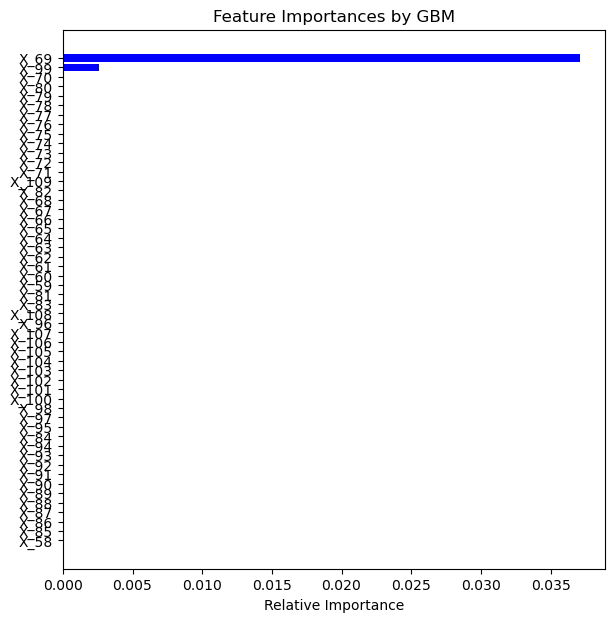

In [64]:
features = train_df.columns[63:115]
importances = gbm.feature_importances_[63:115]
indices = np.argsort(importances)

plt.figure(figsize=(7,7))
plt.title('Feature Importances by GBM')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [18]:
# #train_df_0 index 재설정
# train_df_0 = train_df_0.reset_index(inplace = False, drop = True)
# train_df_0

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03,52.24,55.33,57.49,67.31,1.0,NaN,NaN,NaN,NaN
4,TRAIN_066,0,0.524408,2022-06-25 21:38,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
84,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
